# WaveBot Kinematics
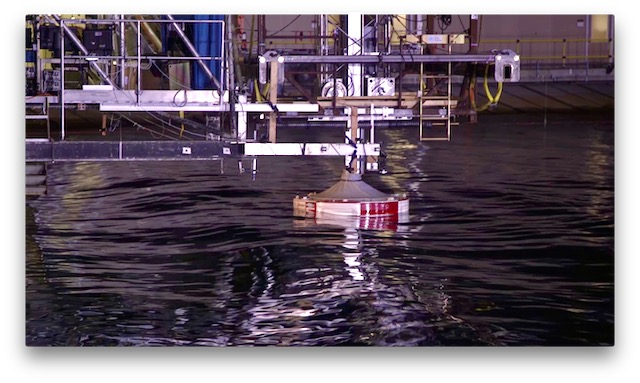

In [1]:
# logging
import logging
logging.basicConfig(level=logging.INFO)

# autograd (derivatives)
import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict

# other packages
import os

import capytaine as cpy
import matplotlib.pyplot as plt

# wecopttool
import wecopttool as wot

# create save directory
results_dir = 'results_kinematics'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

In [2]:
# mesh
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5  # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)

# frequencies
f0 = 0.05
nfreq = 50

# wave
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

## Cases

In [3]:
fb_sh = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb_h = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb_s = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")

# DOFs
fb_sh.add_translation_dof(name="SURGE")
fb_sh.add_translation_dof(name="HEAVE")
fb_s.add_translation_dof(name="SURGE")
fb_h.add_translation_dof(name="HEAVE")

# hydrostatics 
hs_data = wot.hydrostatics.hydrostatics(fb_sh)
mass_11 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[0, 0]
mass_13 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[0, 2]
mass_31 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 0]
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
stiffness_11 = wot.hydrostatics.stiffness_matrix(hs_data)[0, 0]
stiffness_13 = wot.hydrostatics.stiffness_matrix(hs_data)[0, 2]
stiffness_31 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 0]
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
mass_sh = np.array([[mass_11, mass_13], [mass_31, mass_33]])
mass_s = np.array([[mass_11]])
mass_h = np.array([[mass_33]])
stiffness_sh = np.array(
    [[stiffness_11, stiffness_13], [stiffness_31, stiffness_33]])
stiffness_s = np.array([[stiffness_11]])
stiffness_h = np.array([[stiffness_33]])

# kinematics
kinematics_sh_sh = np.eye(fb_sh.nb_dofs)
kinematics_sh_s = np.array([[1.0, 0.0]])
kinematics_sh_h = np.array([[0.0, 1.0]])
kinematics_sh_sh = np.eye(fb_sh.nb_dofs)
kinematics_s = np.eye(fb_s.nb_dofs)
kinematics_h = np.eye(fb_h.nb_dofs)

# PTO
names_sh = ["PTO_SURGE", "PTO_HEAVE"]
names_s = ["PTO_SURGE"]
names_h = ["PTO_HEAVE"]
pto_sh_sh = wot.pto.PseudoSpectralPTO(nfreq, kinematics_sh_sh, names=names_sh)
pto_sh_s = wot.pto.PseudoSpectralPTO(nfreq, kinematics_sh_s, names=names_s)
pto_sh_h = wot.pto.PseudoSpectralPTO(nfreq, kinematics_sh_h, names=names_h)
pto_s = wot.pto.PseudoSpectralPTO(nfreq, kinematics_s, names=names_s)
pto_h = wot.pto.PseudoSpectralPTO(nfreq, kinematics_h, names=names_h)

# f_add 
f_add_sh_sh = pto_sh_sh.force_on_wec
f_add_sh_s = pto_sh_s.force_on_wec
f_add_sh_h = pto_sh_h.force_on_wec
f_add_s = pto_s.force_on_wec
f_add_h = pto_h.force_on_wec

# WEC
wec_sh_sh = wot.WEC(fb_sh, mass_sh, stiffness_sh, f0, nfreq, f_add=f_add_sh_sh)
wec_sh_s = wot.WEC(fb_sh, mass_sh, stiffness_sh, f0, nfreq, f_add=f_add_sh_s)
wec_sh_h = wot.WEC(fb_sh, mass_sh, stiffness_sh, f0, nfreq, f_add=f_add_sh_h)
wec_s = wot.WEC(fb_s, mass_s, stiffness_s, f0, nfreq, f_add=f_add_s)
wec_h = wot.WEC(fb_h, mass_h, stiffness_h, f0, nfreq, f_add=f_add_h)

# BEM files
fname_sh = os.path.join(results_dir, 'bem_sh.nc')
fname_s = os.path.join(results_dir, 'bem_s.nc')
fname_h = os.path.join(results_dir, 'bem_h.nc')


INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:New WEC: WaveBot with 2 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 2 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 2 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.


In [4]:
# # one time (run, comment out, restart & rerun notebook)
# wec_sh_sh.run_bem()
# wec_sh_sh.hydro.added_mass[:, 0, 1] = 0.0
# wec_sh_sh.hydro.added_mass[:, 1, 0] = 0.0
# wec_sh_sh.hydro.radiation_damping[:, 0, 1] = 0.0
# wec_sh_sh.hydro.radiation_damping[:, 1, 0] = 0.0
# wec_sh_sh._del_impedance()
# wec_sh_sh.bem_calc_impedance()
# wec_sh_sh.write_bem(fname_sh)

# wec_s.run_bem()
# wec_s.write_bem(fname_s)

# wec_h.run_bem()
# wec_h.write_bem(fname_h)

In [5]:
# Read BEM
wec_sh_sh.read_bem(fname_sh)
wec_sh_s.read_bem(fname_sh)
wec_sh_h.read_bem(fname_sh)
wec_s.read_bem(fname_s)
wec_h.read_bem(fname_h)

INFO:wecopttool.core:Reading BEM data from results_kinematics/bem_sh.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.
INFO:wecopttool.core:Reading BEM data from results_kinematics/bem_sh.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.
INFO:wecopttool.core:Reading BEM data from results_kinematics/bem_sh.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculat

## Solve cases

In [6]:
# sh_sh
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_sh_sh  # change
wec = wec_sh_sh  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_sh_sh = {"wec_tdom": wec_tdom, 
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.99e-02, 4.15e-01, 8.01e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.99e-02, 4.15e-01, 8.62e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.99e-02, 4.13e-01, 1.17e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.99e-02, 4.06e-01, 2.70e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.00e-02, 3.70e-01, 1.03e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.00e-02, 1.88e-01, 4.83e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.03e-02, 7.17e-01, 2.33e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.16e-02, 5.09e+00, 1.04e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.71e-02, 2.34e+01, 2.85e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.83e-02, 2.74e+01, 2.92e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -416.7912894102463
            Iterations: 99
            Function evaluations: 109
            Gradient evaluations: 99
Average power: -416.7912894102463 W



In [7]:
# sh_s
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_sh_s  # change
wec = wec_sh_s  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_sh_s = {"wec_tdom": wec_tdom,
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.24e-02, 7.22e-02, 1.26e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.24e-02, 7.29e-02, 1.52e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.24e-02, 7.64e-02, 2.82e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.24e-02, 9.42e-02, 9.29e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.24e-02, 1.83e-01, 4.16e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.23e-02, 6.26e-01, 2.03e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.20e-02, 2.84e+00, 1.00e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.08e-02, 1.37e+01, 4.76e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.96e-03, 6.42e+01, 1.84e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.10e-03, 1.52e+02, 2.77e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -276.65831894713165
            Iterations: 15
            Function evaluations: 31
            Gradient evaluations: 15
Average power: -276.65831894713165 W



In [8]:
# sh_h
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_sh_h  # change
wec = wec_sh_h  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_sh_h = {"wec_tdom": wec_tdom,
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.72e-01, 4.36e-01, 6.67e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.71e-01, 4.36e-01, 6.31e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.70e-01, 4.36e-01, 5.37e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.70e-01, 4.36e-01, 1.64e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.69e-01, 4.37e-01, 1.35e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.69e-01, 4.46e-01, 7.82e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.69e-01, 4.90e-01, 3.98e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.70e-01, 7.14e-01, 1.97e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.69e-01, 1.97e+00, 8.88e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.69e-01, 3.97e+00, 1.30e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -139.99462722269024
            Iterations: 39
            Function evaluations: 132
            Gradient evaluations: 39
Average power: -139.99462722269024 W



In [9]:
# s
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_s  # change
wec = wec_s  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_s = {"wec_tdom": wec_tdom,
                 "wec_fdom": wec_fdom,
                 "x_wec": x_wec,
                 "x_opt": x_opt,
                 "obj": obj,
                 "res": res,
                 "pto_tdom": pto_tdom,
                 "pto_fdom": pto_fdom,
                 }


INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.74e-02, 1.14e-01, 2.14e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.74e-02, 1.13e-01, 1.88e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.75e-02, 1.09e-01, 5.83e-03]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.75e-02, 9.18e-02, 5.89e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.75e-02, 3.29e-03, 3.82e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.76e-02, 4.39e-01, 2.00e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.81e-02, 2.64e+00, 9.97e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [3.07e-02, 1.35e+01, 4.75e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.23e-02, 6.38e+01, 1.84e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.24e-02, 1.51e+02, 2.77e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -276.78661446362077
            Iterations: 23
            Function evaluations: 42
            Gradient evaluations: 23
Average power: -276.78661446362077 W



In [10]:
# h
scale_x_wec = 1.0
scale_x_opt = 1.0
scale_obj = 1.0

options = {'maxiter': 1000, 'ftol': 1e-8}

pto = pto_h  # change
wec = wec_h  # change

obj_fun = pto.average_power
nstate_opt = pto.nstate

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

print(f"Average power: {obj} W\n")

# change
results_h = {"wec_tdom": wec_tdom,
             "wec_fdom": wec_fdom,
             "x_wec": x_wec,
             "x_opt": x_opt,
             "obj": obj,
             "res": res,
             "pto_tdom": pto_tdom,
             "pto_fdom": pto_fdom,
             }

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.66e-04, 2.08e-01, 6.03e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.66e-04, 2.08e-01, 6.39e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.66e-04, 2.09e-01, 8.14e-02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.66e-04, 2.13e-01, 1.69e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.65e-04, 2.30e-01, 6.07e-01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.59e-04, 3.19e-01, 2.78e+00]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [8.29e-04, 7.56e-01, 1.33e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [6.90e-04, 2.85e+00, 5.76e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.52e-04, 1.09e+01, 1.33e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.52e-04, 1.09e+01, 1.33e+02]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -140.00323660790886
            Iterations: 56
            Function evaluations: 56
            Gradient evaluations: 56
Average power: -140.00323660790886 W



## Results

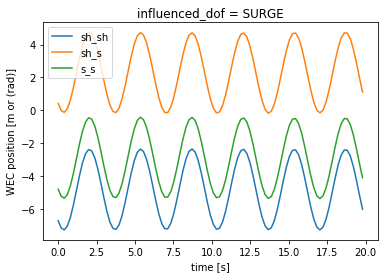

In [11]:
# WEC Position - Surge
results_sh_sh["wec_tdom"]["pos"].sel(influenced_dof="SURGE").plot(label='sh_sh')
results_sh_s["wec_tdom"]["pos"].sel(influenced_dof="SURGE").plot(label='sh_s')
results_s["wec_tdom"]["pos"].sel(influenced_dof="SURGE").plot(label='s_s')
plt.legend()

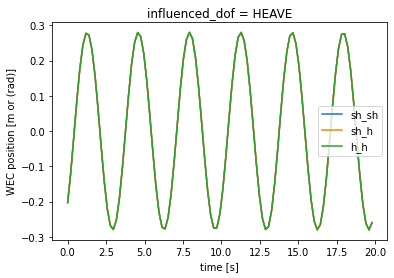

In [12]:
# WEC Position - Heave
results_sh_sh["wec_tdom"]["pos"].sel(influenced_dof="HEAVE").plot(label='sh_sh')
results_sh_h["wec_tdom"]["pos"].sel(influenced_dof="HEAVE").plot(label='sh_h')
results_h["wec_tdom"]["pos"].sel(influenced_dof="HEAVE").plot(label='h_h')
plt.legend()

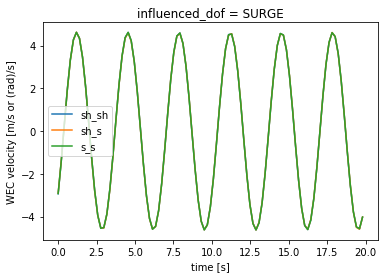

In [13]:
# WEC Velocity - Surge
results_sh_sh["wec_tdom"]["vel"].sel(influenced_dof="SURGE").plot(label='sh_sh')
results_sh_s["wec_tdom"]["vel"].sel(influenced_dof="SURGE").plot(label='sh_s')
results_s["wec_tdom"]["vel"].sel(influenced_dof="SURGE").plot(label='s_s')
plt.legend()

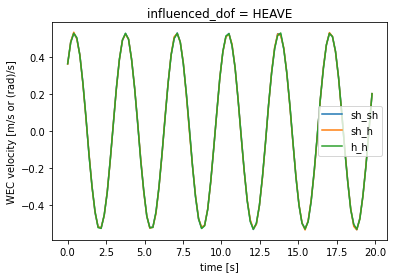

In [14]:
# WEC Velocity - Heave
results_sh_sh["wec_tdom"]["vel"].sel(influenced_dof="HEAVE").plot(label='sh_sh')
results_sh_h["wec_tdom"]["vel"].sel(influenced_dof="HEAVE").plot(label='sh_h')
results_h["wec_tdom"]["vel"].sel(influenced_dof="HEAVE").plot(label='h_h')
plt.legend()

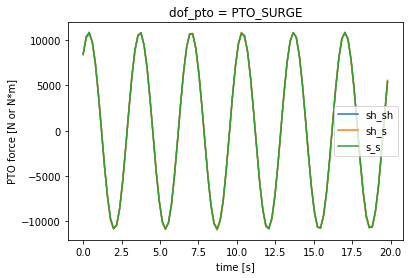

In [15]:
# PTO Force - Surge
results_sh_sh["pto_tdom"]["force"].sel(dof_pto="PTO_SURGE").plot(label='sh_sh')
results_sh_s["pto_tdom"]["force"].sel(dof_pto="PTO_SURGE").plot(label='sh_s')
results_s["pto_tdom"]["force"].sel(dof_pto="PTO_SURGE").plot(label='s_s')
plt.legend()

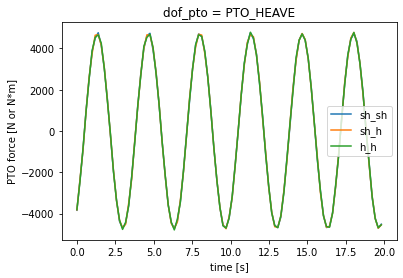

In [16]:
# PTO Force - Heave
results_sh_sh["pto_tdom"]["force"].sel(dof_pto="PTO_HEAVE").plot(label='sh_sh')
results_sh_h["pto_tdom"]["force"].sel(dof_pto="PTO_HEAVE").plot(label='sh_h')
results_h["pto_tdom"]["force"].sel(dof_pto="PTO_HEAVE").plot(label='h_h')
plt.legend()

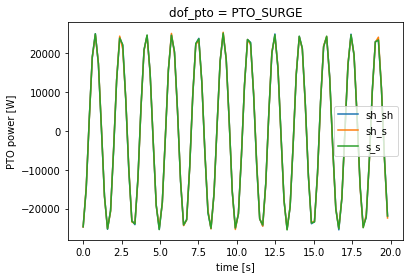

In [17]:
# PTO Power - Surge
results_sh_sh["pto_tdom"]["power"].sel(dof_pto="PTO_SURGE").plot(label='sh_sh')
results_sh_s["pto_tdom"]["power"].sel(dof_pto="PTO_SURGE").plot(label='sh_s')
results_s["pto_tdom"]["power"].sel(dof_pto="PTO_SURGE").plot(label='s_s')
plt.legend()

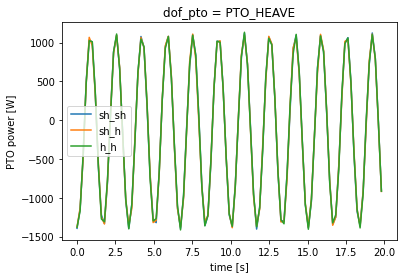

In [18]:
# PTO Power - Heave
results_sh_sh["pto_tdom"]["power"].sel(dof_pto="PTO_HEAVE").plot(label='sh_sh')
results_sh_h["pto_tdom"]["power"].sel(dof_pto="PTO_HEAVE").plot(label='sh_h')
results_h["pto_tdom"]["power"].sel(dof_pto="PTO_HEAVE").plot(label='h_h')
plt.legend()